Single cell RNA sequencing (scRNA-Seq) is a fascinating way of getting insights into the molecular processes guiding an individual cell. While RNA wont provide the full picture on the inner workings of a cell, proteins, hormones and nutrients will have a say in that too, it certainly is a part of the puzzle. 

For quite some time researchers have had the ability to not only look at one cell, but hundreds or thousands of cells. Projects such as the [Human Cell Atlas](https://www.humancellatlas.org/) show what is possible. 

Today I am taking a step back and looked for a paper that published a single cell atlas of a size that I can process it in a week at home, rather than needing a full research cluster at my hands. 

The choice fell on the 2015 Science publication by [Zeisel et al](https://pubmed.ncbi.nlm.nih.gov/25700174/): "Brain structure. Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq"


In that publication scRNA-Seq was appled to cells from mouse brain tissues. I will be downloading the datasets and try to recreate figure 1B panels 2-10. Figure 1B panel 1 shows the clustering algorithm implemented by that team, which I might attempt later but have shelved for this week. 

## Getting the Data

Lucky for me the sequencing data was deposited and can be found in ENA under accession [PRJNA258094](https://www.ebi.ac.uk/ena/browser/view/PRJNA258094). In total over 3000 fastq files are grouped under this accession, each sequencing file seems to be a single cell, meaning the sequencing data has already been conveniently split for later use. 

Looking at one of these fastq files I notice that reads are relatively short (52 bp). According to the paper each read starts with a 6bp UMI followed by 3-5 guanines, followed by the 5’ end of the transcript. Here are 3 reads from one of the datasets to get an idea of what I am talking about:


```txt
@SRR1544698.1 Run0199_AC237YACXX_L2_T1101_C32 length=52
CTAGACGGGGGGAATTCTGGACATTAATTAGGGCTGAAAGCCCTAACTTAAT
+SRR1544698.1 Run0199_AC237YACXX_L2_T1101_C32 length=52
@@@FFFFFHHHDDDDDDEEDDDDDDDDEEEDDDDDDDDDDDDDDDDDDEDDE
@SRR1544698.2 Run0199_AC237YACXX_L2_T1101_C64 length=52
ACACATGGGGGAATTCTCTTGCTTCAACAATAACGTCTCTTTCAGAAGGCAT
+SRR1544698.2 Run0199_AC237YACXX_L2_T1101_C64 length=52
BCCFFFFFHHHHHIIIIIIIIIIIIIIIIIIIIIIGIIIIIIIIIIIIIIII
```

The first read then can be split into these sections:

```txt
  UMI    Gs            Transcript
CTAGAC GGGGG GAATTCTGGACATTAATTAGGGCTGAAAGCCCTAACTTAAT
```

Aligning transcripts directly against a genome might cause issues, as we only have exons here and this might lead to lower quality alignments than expected. As such to process these reads I will be using software designed to handle both UMIs and gapped alignments.

After a bit of looking around and testing I decided to use the Subread package together with umi_tools. I tried using the STAR aligner but it needed to much memory for creation of the index, but I am getting ahead of myself. 

Overall I will be leaning on information provided by the UMI-Tools package on how to process single-cell data with their software, This information can be found here: [https://umi-tools.readthedocs.io/en/latest/Single_cell_tutorial.html](https://umi-tools.readthedocs.io/en/latest/Single_cell_tutorial.html)

### Python Environment

Like last time I am using mamba to get a python environment setup quickly. Note that I have my channels configured, so I am using bioconda implicitly here.

```sh
mamba create -n reproduce_single_cell python==3.11 uv==0.3.3 samtools subread umi_tools
mamba activate reproduce_single_cell
uv pip install plotnine==0.13.6 pandas==2.2.2 pysam==0.22.1 scipy==1.14.1 numpy==1.25.2 biopython==1.82 pydantic==2.8.2 dask==2024.8.2
```

## Processing scRNA-Seq data

I already know that I will first need to process over 3000 fastq files to get count data. Only then can I move on to the analysis section. As it is quite a committment to process 3000 files on a single desktop machine, I first set out to process a single file. Once that works, I will scale it up. 


### Getting the References

Besides the seqeuencing data I will be needeing a mouse reference genome and a corresponding map of all the genes on that genome. 

Both of these are easy to find on ENSEMBL.

```sh
wget -P ./data/02/ -c https://ftp.ensembl.org/pub/release-112/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz
wget -P ./data/02/ -c https://ftp.ensembl.org/pub/release-112/gtf/mus_musculus/Mus_musculus.GRCm39.112.gtf.gz

# Decompress the data
gunzip ./data/02/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz
gunzip ./data/02/Mus_musculus.GRCm39.112.gtf.gz
```

Before using an aligner the first step is to create an index, this is also true for Subread:

```sh
subread-buildindex -o ./data/02/genome_index ./data/02/Mus_musculus.GRCm39.dna.primary_assembly.fa
```

### Processing the first Dataset



- 8bp barcode
reads can be found here: https://www.ebi.ac.uk/ena/browser/view/PRJNA258094
summary table can be found here

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60361


In [ ]:
%%bash
mkdir -p data/02/

mamba install -y bioconda::star bioconda::umi_tools bioconda::subread


In [ ]:
%%bash
cd data/02/
gunzip Mus_musculus.GRCm39.dna.primary_assembly.fa.gz
subread-buildindex -o genome_index Mus_musculus.GRCm39.dna.primary_assembly.fa


So now we have to index, we can start processing files. After some testing I cam up with this script for processing eacsh fastq file from this dataset.
I saved this under `./data/02/align.sh` and will be using it to process the read datasets.

```sh
#!/bin/bash

# Function to check for required dependencies
check_dependencies() {
    for cmd in umi_tools subread-align samtools featureCounts; do
        if ! command -v $cmd &> /dev/null; then
            echo "Error: $cmd is not installed. Please install it and try again."
            exit 1
        fi
    done
}

# Function to display usage
usage() {
    echo "Usage: $0 <reads_file.fastq.gz> <threads> <output_directory> <geneset_file> <genome_index>"
    exit 1
}

# Function to clean up temporary files
cleanup() {
    rm -rf "$TEMP_DIR"
}

# Check for correct number of arguments
if [ "$#" -ne 5 ]; then
    usage
fi

# Set variables
READS_FILE="$1"
THREADS="$2"
OUTPUT_DIR="$3"
GENESET_FILE="$4"
GENOME_INDEX="$5"
TEMP_DIR=$(mktemp -d)
COUNTS_OUTPUT="$OUTPUT_DIR/$(basename "$READS_FILE" .fastq.gz)_counts.tsv.gz"

# Check for dependencies
check_dependencies

# Trap to clean up temporary files on exit
trap cleanup EXIT

# Main processing
{
    UMI_READS="$TEMP_DIR/reads_umi.fastq.gz"
    GROUPED_BAM="$TEMP_DIR/grouped.bam"
    DEDUPLICATED_BAM="$TEMP_DIR/deduplicated.bam"
    ALIGNED_BAM="$TEMP_DIR/aligned.bam"
    SORTED_BAM="$TEMP_DIR/sorted.bam"
    ASSIGNED_SORTED_BAM="$TEMP_DIR/assigned_sorted.bam"
    FEATURECOUNTS_OUTPUT="$TEMP_DIR/featureCounts_output.txt"

    # Extract UMI
    umi_tools extract --bc-pattern=NNNNNN -S "$UMI_READS" -I "$READS_FILE" || { echo "Error in UMI extraction"; exit 1; }

    # Align reads
    subread-align -t 0 -i "$GENOME_INDEX" -r "$UMI_READS" -o "$ALIGNED_BAM" || { echo "Error in alignment"; exit 1; }

    # Sort aligned BAM
    samtools sort "$ALIGNED_BAM" -o "$SORTED_BAM" || { echo "Error in sorting BAM"; exit 1; }
    samtools index "$SORTED_BAM" || { echo "Error in indexing sorted BAM"; exit 1; }
   
    # Count features
    featureCounts -T "$THREADS" -a "$GENESET_FILE" -o "$FEATURECOUNTS_OUTPUT" -R BAM "$SORTED_BAM" || { echo "Error in feature counting"; exit 1; }

    # Sort assigned BAM (using the correct output from featureCounts)
    samtools sort "${SORTED_BAM}.featureCounts.bam" -o "$ASSIGNED_SORTED_BAM" || { echo "Error in sorting assigned BAM"; exit 1; }
    samtools index "$ASSIGNED_SORTED_BAM" || { echo "Error in indexing assigned sorted BAM"; exit 1; }

     # Group UMI reads
    umi_tools group --output-bam -I "$ASSIGNED_SORTED_BAM"  -S "$GROUPED_BAM" || { echo "Error in grouping UMI reads"; exit 1; }
    samtools index "$GROUPED_BAM" || { echo "Error in indexing grouped BAM"; exit 1; }

    # Deduplicate reads
    umi_tools dedup -I "$GROUPED_BAM" -S "$DEDUPLICATED_BAM" || { echo "Error in deduplication"; exit 1; }
    samtools index "$DEDUPLICATED_BAM" || { echo "Error in indexing deduplicated BAM"; exit 1; }


    # Count UMI reads
    umi_tools count --per-gene --gene-tag=XT --assigned-status-tag=XS -I "$DEDUPLICATED_BAM" -S "$COUNTS_OUTPUT" || { echo "Error in UMI counting"; exit 1; }

    # Check if counts file exists
    if [ -f "$COUNTS_OUTPUT" ]; then
        echo "Counts file saved to $COUNTS_OUTPUT"
    else
        echo "Error: Counts file not generated."
        exit 1
    fi
} || {
    echo "An error occurred during processing."
    exit 1
}
```

Here are the steps this script accomplishes lined out in brief:

1. Extract the UMI from the first 6 bases
2. Align the reads to the reference with subread
3. Sort and index the resulting bam file
4. Assign each read to a transcript
5. Group all reads assigned to the same transcript
6. Deduplicate within each transcript based on the UMI
7. Report number of unique reads per transcript


That seems reassonable to me, so now lets move on and run this for all 3492 datasets.
This might take a while and we need to make sure we delete the fastq files once we processed the data successfully.

Lets first get the table of all datasets. I am simply downloading that from [ENA](https://www.ebi.ac.uk/ena/browser/view/PRJNA258094):

```sh
curl -o ./data/02/dataset.tsv https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJNA258094&result=read_run&fields=study_accession,sample_accession,experiment_accession,run_accession,library_strategy,read_count,experiment_title,run_alias,fastq_ftp,sra_ftp,sample_alias,sample_title&format=tsv&download=true&limit=0
```



In [ ]:
%%bash
#!/bin/bash

# Set variables
OUTPUT_DIR="./data/02/counts"
THREADS=3
GNUTHREADS=4
GTF="data/02/Mus_musculus.GRCm39.112.gtf"
INDEX="data/02/genome_index"
DATASET="./data/02/dataset.tsv"
ALIGNSH="./data/02/align.sh"

# Create output directory if it doesn't exist
mkdir -p "$OUTPUT_DIR"

# Get the column number of fastq_ftp
HEADER=$(head -n 1 "$DATASET")
FASTQ_COL=$(echo "$HEADER" | tr '\t' '\n' | nl -w1 -s' ' | grep -w 'fastq_ftp' | awk '{print $1}')

if [ -z "$FASTQ_COL" ]; then
    echo "Error: fastq_ftp column not found in the dataset."
    exit 1
fi

# Function to process each line
process_line() {
    line="$1"
    fastqcol=$2

    FASTQFILE=$(echo "$line" | cut -f"$fastqcol")
    FASTQFILE_NAME=$(basename "$FASTQFILE")
    COUNTS_OUTPUT="$OUTPUT_DIR/${FASTQFILE_NAME%.fastq.gz}_counts.tsv.gz"

    # Check if counts file already exists
    if [ -f "$COUNTS_OUTPUT" ]; then
        echo "Counts file already exists for: $FASTQFILE_NAME, skipping."
        return
    fi

    # Download the FASTQ file
    echo "Downloading FASTQ file from: $FASTQFILE"
    wget -c -q "$FASTQFILE" -O "data/$FASTQFILE_NAME" || { echo "Error downloading $FASTQFILE"; exit 1; }

    # Run the align.sh script
    bash "$ALIGNSH" "data/$FASTQFILE_NAME" "$THREADS" "$OUTPUT_DIR" "$GTF" "$INDEX" > /dev/null 2> /dev/null

    # Delete the FASTQ file after processing
    rm "data/$FASTQFILE_NAME"
}

export -f process_line
export OUTPUT_DIR THREADS GTF INDEX ALIGNSH

# Loop through each line in the dataset, skipping the header and use parallel
tail -n +2 "$DATASET"  | parallel -j "$GNUTHREADS" process_line {} $FASTQ_COL


This took quite some time. I had to interrupt it a few times as I do need my computer also for non bioinformatics related stuff, but for the most time this was ticking along.

Could have sped this up by using a few more threads, maybe using gnu parallel to multithread the downloads etc. 

In [ ]:
from glob import glob
import dask.dataframe as dd
import os
from tqdm import tqdm
import pandas as pd

dataset_cache_location = "./data/02/count_table.csv.gz"
if os.path.exists(dataset_cache_location):
    df = pd.read_csv(dataset_cache_location, index_col=0)
else:
    # Get all file paths
    files = glob("data/02/counts/*")

    # Initialize an empty list to hold Dask DataFrames
    dataframes = []

    # Loop through each file
    for file in tqdm(files, desc="Loading dataframes"):
        df = dd.read_csv(file, sep="\t", blocksize=None)
        filename = os.path.basename(file)
        new_column_name = filename.split('_')[0]
        df['cell'] = new_column_name
        dataframes.append(df)

    # Now I concatenate the dataframes and construct a full matrix
    combined_df = dd.concat(dataframes)
    combined_df = combined_df.compute()
    df = combined_df.pivot_table(index='gene', columns='cell', values='count', fill_value=0)
    del combined_df, dataframes
    df.to_csv(dataset_cache_location, index = True)

# Later I will need this dataframe transposed as well
df_transposed = df.T.copy()
df_transposed.reset_index(inplace=True)
df_transposed.rename(columns={'index': 'cell'}, inplace=True)
df_transposed = df_transposed.rename_axis(None, axis=1).reset_index(drop=True)
df_transposed.head()

Now I have a table with ENSEMBLE ids but later on I want to have gene names, so I will use the GTF I have to quickly get a mapping from ENSEMBLE ID to gene name. This yields a mapping of 57.186 ENSEMBLE ids to their gene names in seconds, and is much faster than blasting the REST API for hours. Also as this is the same GTF file I used during processing earlier, it is guaranteed that all IDs I need are present.

In [ ]:
ensemble_mapping = {}

gtf_file = "data/02/Mus_musculus.GRCm39.112.gtf"
gtf_df = pd.read_csv(gtf_file, sep='\t', comment='#', header=None, low_memory=False)
gtf_df.columns = [
    'seqname', 'source', 'feature', 'start', 'end', 
    'score', 'strand', 'frame', 'attribute'
]
gtf_df = gtf_df[gtf_df.feature == "gene"]

def obtain_attributes(attribute_str: str) -> dict:
    attributes = {}
    for e in attribute_str.split(';'):
        e = e.strip()
        if e:
            try:
                a, b = e.split(' ', 1)  
                attributes[a] = b.strip('"')
            except ValueError:
                print(f"Warning: Could not parse attribute '{e}'")
    return attributes

for attribute_str in gtf_df.attribute.values:
    attributes = obtain_attributes(attribute_str)
    ensemble_mapping[attributes.get("gene_id")] = attributes.get("gene_name")

all_ids_present = len(set(df.index.to_list()).intersection(set(ensemble_mapping.keys()))) == len(set(df.index.to_list()))

print(f"Created mapping for {len(ensemble_mapping)} IDs, which contains all IDs we need: {all_ids_present}")

In [ ]:
import plotnine as p9

df_colsums = df.sum().reset_index()
df_colsums.columns = ['cell', 'gene_count']
(
    p9.ggplot(df_colsums, p9.aes(x='gene_count')) +
    p9.geom_histogram(bins=50, fill='blue', color='black') +
    p9.labs(title='Number of Reads per Cell', x='Reads per Cell', y='Frequency', subtitle="Minimum of 2500 shown by red line") + 
    p9.geom_vline(xintercept=2500, color = "red", linetype="dashed") +
    p9.theme_light()
)


In [ ]:
import pandas as pd
import numpy as np

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def noise_model(mean, alpha, k):
    """Noise model function."""
    return np.log2(mean**alpha + k)

def fit_noise_model(means, cv):
    """Fit the noise model to the data and return the fitted parameters."""
    initial_guess = [0,0]# Initial guess for alpha and k could be [-0.55, 0.64]
    # Remove any means that are zero to avoid log(0)
    valid_indices = means > 0
    means_valid = means[valid_indices]
    cv_valid = cv[valid_indices]

    # Fit the model
    popt, _ = curve_fit(noise_model, means_valid, np.log2(cv_valid), p0=initial_guess)
    return popt  # Returns fitted parameters (alpha, k)

def filter_genes(df_transposed):
    
    # Step 1: Remove cells with less than 2500 total detected RNA molecules
    data = df_transposed.drop(columns='cell').copy()
    print(f"Input data {data.shape}")
    data = data[data.sum(axis=1) >= 2500]
    print(f"After removing low count cells {data.shape}")


    # Step 2: Remove genes with less than 25 total molecules across all cells
    print("Remove low frequency genes")
    gene_totals = data.sum(axis=0)
    data = data.loc[:, gene_totals >= 25]
    print(f"data shape {data.shape}")
    
    # Step 3: Calculate the correlation matrix using numpy.corrcoef
    print("Computing correlation matrix")
    correlation_matrix = np.corrcoef(data.T)  # Transpose to get genes as rows
    print(f"Correlation matrix shape: {correlation_matrix.shape}")
    threshold = np.percentile(correlation_matrix, 90)  # 90th percentile
    threshold = threshold if threshold > 0 else 0  # Ensure threshold is non-negative
    print(f"Percentile threshold is {threshold}")

    # Step 4: Remove genes with less than 5 other genes correlating above the threshold
    print("Remove genes which have less than 5 other genes which correlate more than this threshold")
    valid_genes = []
    for i, gene in enumerate(data.columns):
        correlations = correlation_matrix[i]
        if (correlations > threshold).sum() - 1 >= 5:  # Subtract 1 to exclude self-correlation
            valid_genes.append(gene)
            
    data = data[valid_genes]
    print(f"Valid genes {data.shape}")

    # Step 5: Calculate mean and coefficient of variation (CV)
    means = data.mean()
    std_devs = data.std()
    cv = std_devs / means

    # Step 6: Fit the noise model
    print("Fitting the noise model")
    alpha, k = fit_noise_model(means, cv)
    print(f"Fitted parameters: alpha = {alpha}, k = {k}")

    # Step 7: Calculate the fitted values and distances from the fit line
    fitted_values = noise_model(means, alpha, k)
    cv_log = np.log2(cv)

    # Step 8: Calculate the distance from the fit line
    distances = np.abs(cv_log - fitted_values)

    # Step 9: Rank genes by distance and select the top 5000
    ranked_genes = distances.nlargest(5000).index
    filtered_data = data[ranked_genes]

    return filtered_data

#filtered_genes = filter_genes(df_transposed)

In [30]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotnine as p9


! mkdir -p "./data/02/tsneplots/"



def make_tsne(df):

    # Step 2: Standardize the Data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df.drop(columns="cell"))

    # Step 3: Apply t-SNE
    tsne = TSNE(n_components=2, 
                init="pca",
                early_exaggeration = 12.0,
                learning_rate = "auto",
                n_iter = 2000,
                method = "barnes_hut",
                angle=0.05,
                random_state=12345, 
                perplexity=50
                )
    tsne_results = tsne.fit_transform(data_scaled)

    # Create a DataFrame for the t-SNE results
    tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['cell'] = df["cell"]
    kmeans = KMeans(n_clusters=9, random_state=42, 
                    n_init = 'auto')
    tsne_df['cluster'] = kmeans.fit_predict(tsne_results)
    tsne_df['cluster'] = tsne_df['cluster'].astype(str)
    return tsne_df

def plot_tsne(df, gene: str):

    if gene == "cluster":
        df["intensity"] = df["cluster"]

        plot_data = df
    else:    
        reverse_mapping = {v: k for k,v in ensemble_mapping.items()}
        df["intensity"] = df_transposed[reverse_mapping[gene]]
        quantiles = df['intensity'].quantile([0.01, 0.99]).values.tolist()
        plot_data = df[df["intensity"] > 0]
        

    tsne_plot = (
        p9.ggplot(plot_data, p9.aes(x='TSNE1', y='TSNE2', fill='intensity')) +
            p9.geom_point(size=3, stroke=0, alpha=1) +
            p9.labs(title=gene, x='t-SNE Component 1', y='t-SNE Component 2') +
            p9.theme_light() +
            p9.theme(
                plot_title=p9.element_text(size=50),
                axis_title=p9.element_blank(), 
                axis_text=p9.element_blank(), 
                legend_position='none', 
                panel_grid=p9.element_blank(),
                panel_background=p9.element_blank(),
                panel_border=p9.element_blank()
            )
    )

    if gene != "cluster":
        tsne_plot = (tsne_plot + 
                     p9.geom_point(data = df[df['intensity'] == 0], fill = "blue", size = 3, stroke=0)
                    ) 
    # add nice outline to the points
    tsne_plot = (tsne_plot + p9.geom_point(data = df, size=3, fill="none", stroke=0.1))

    if gene == "cluster":
        tsne_plot  = tsne_plot  #+ p9.scale_fill_discrete()
    else:
        tsne_plot  = tsne_plot + p9.scale_fill_gradient2(low="blue", mid="white", high="red", 
                                                         midpoint=quantiles[0], 
                                                         limits=(0, quantiles[1]), 
                                                         na_value="red",
                                                         name="Count") 

    return tsne_plot

! rm ./data/02/tsneplots/*.png
gene_list_ordered = ["Thy1", "Gad1", "Tbr1", "Spink8", "Mbp", "Aldoc", "Aif1", "Cldn5", "Acta2"]
#tsne_df = make_tsne(df_transposed.copy())

for i, gene in enumerate(["cluster"] + gene_list_ordered):
    p = plot_tsne(tsne_df.copy(), gene)
    p9.ggsave(p, filename = f"./data/02/tsneplots/{i}_{gene}.png", width = 6, height = 6, verbose=False, dpi = 300)

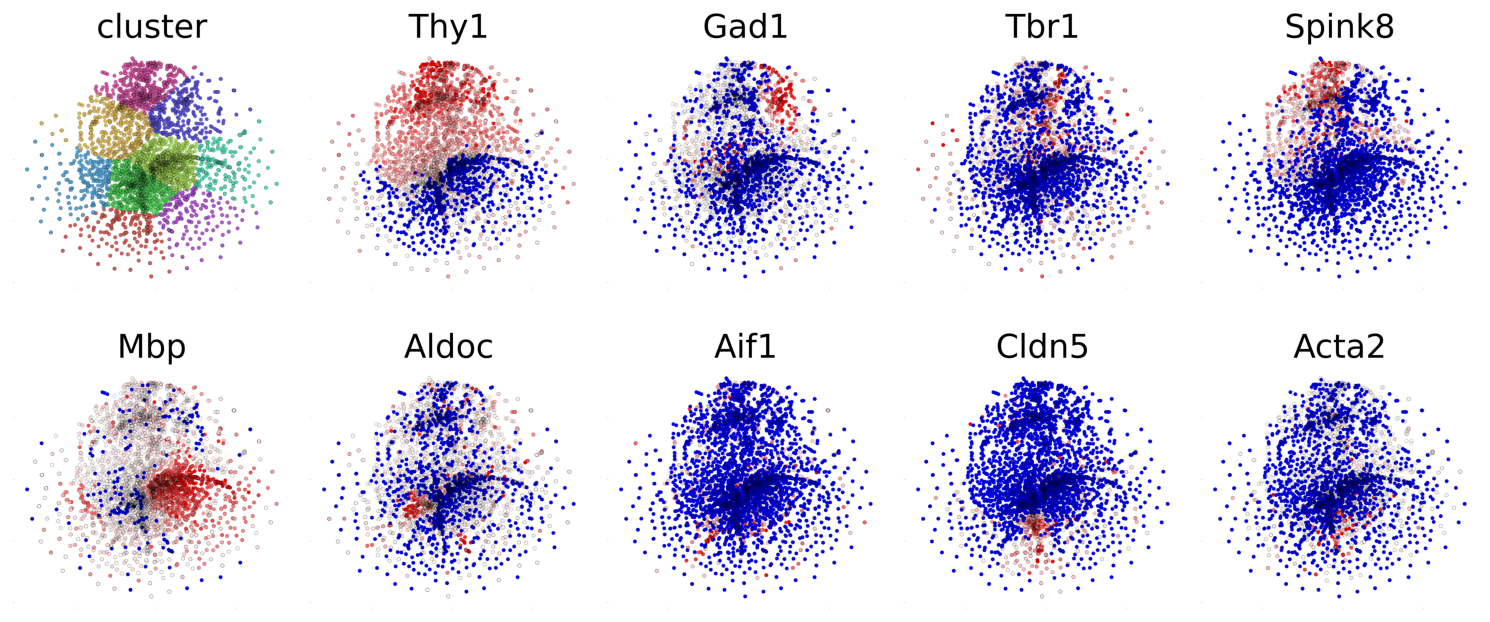

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Specify the folder containing the PNG images
folder_path = './data/02/tsneplots/'

# Get a list of all PNG files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
image_files.sort()

# Check if there are at least 10 images
if len(image_files) < 10:
    raise ValueError("Not enough PNG images in the folder. At least 10 are required.")

# Create a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 5, figsize=(15, 7))

# Loop through the first 8 images and display them
for i in range(2):
    for j in range(5):
        img_index = i * 5 + j
        img_path = os.path.join(folder_path, image_files[img_index])
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')  # Hide the axes

# Adjust layout
plt.tight_layout()
plt.show()


## Comparison Against Original Count Data

Besides having published the raw data, the authors also submitted the expression data....

```sh 
wget -c -O ./data/02/GSE60361_C1-3005-Expression.txt.gz https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE60361&format=file&file=GSE60361%5FC1%2D3005%2DExpression%2Etxt%2Egz
```

I can now directly compare my count table against their count table. Here a small preview on the data this file contains:

```txt
cell_id 1772071015_C02  1772071017_G12  1772071017_A05 ...
Tspan12 0       0       0       3       0       0      ...
Tshz1   3       1       0       2       2       2      ...
Fnbp1l  3       1       6       4       1       2      ...
```

Looking at the column (cell) and rows (gene), the table I created has the same structure but different names. The first challenge will be to create a cell to cell and gene to gene mapping so I can compare results.

But before that I will load the data and make a comparison plot to my data.

In [59]:
import pandas as pd
df_original = pd.read_csv("./data/02/GSE60361_C1-3005-Expression.txt.gz", sep = "\t")
print(f"Original has shape {df_original.shape}")
duplicates = set(df_original[df_original.duplicated('cell_id', keep=False)].cell_id.tolist())
print(f"I found {len(duplicates)} duplicated cell ids")
df_original_dedup = df_original.drop_duplicates(subset='cell_id', keep='first').set_index("cell_id")

Original has shape (19972, 3006)
I found 2 duplicated cell ids


In [62]:
import pandas as pd

df2 = df.copy()
df2["cell_id"] = [ensemble_mapping[x] for x in df2.index.values]

# overlap_ids 
overlap = set(df_original_dedup.index.tolist()).intersection(set(df2.cell_id.tolist()))
print(f"Found {len(overlap)} overlapping gene names")


df2 = df2.rename_axis(None, axis=1).reset_index(drop=True).set_index("cell_id")
df2_ordered = df2.reindex(df_original_dedup.index)
df2_ordered

The data table of theirs has 19972 genes and 3005 cells. Meaning this might be the dataset after excluding some cells already but before filtering genes. 
So I should be able to compare it to my dataframe before filtering. 

First I need to find out which cell links to which column of mine. 